In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, make_scorer, recall_score
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
import joblib

In [10]:
# Load the pickled DataFrame
df = pd.read_pickle('polished_data.pkl')

# Verify that the data loaded correctly
print(df.head())


  Gender  Age  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI Class
0      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0     N
1      M   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0     N
2      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0     N
3      F   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0     N
4      M   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0     N


In [11]:


# 1. Preprocessing

# Assuming 'df' is the dataframe containing your data
# Encode categorical columns (e.g., 'Gender' and 'Class')
label_encoder = LabelEncoder()

# Encode 'Gender' column (e.g., M = 1, F = 0)
df['Gender'] = label_encoder.fit_transform(df['Gender'])

# Encode 'Class' column (assuming binary classification: Y = 1, N = 0)
df['Class'] = label_encoder.fit_transform(df['Class'])



In [12]:
print(df.head())

   Gender  Age  Urea  Cr  HbA1c  Chol   TG  HDL  LDL  VLDL   BMI  Class
0       0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      0
1       1   26   4.5  62    4.9   3.7  1.4  1.1  2.1   0.6  23.0      0
2       0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      0
3       0   50   4.7  46    4.9   4.2  0.9  2.4  1.4   0.5  24.0      0
4       1   33   7.1  46    4.9   4.9  1.0  0.8  2.0   0.4  21.0      0


In [13]:
# 2. Split the data into features (X) and target (y)
X = df.drop(columns=['Class'])  # All columns except the target variable 'Class'
y = df['Class']  # Target variable

In [14]:
X.head()

,Gender,Age,Urea,Cr,HbA1c,Chol,TG,HDL,LDL,VLDL,BMI
0,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
1,1,26,4.5,62,4.9,3.7,1.4,1.1,2.1,0.6,23.0
2,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
3,0,50,4.7,46,4.9,4.2,0.9,2.4,1.4,0.5,24.0
4,1,33,7.1,46,4.9,4.9,1.0,0.8,2.0,0.4,21.0


In [15]:
y.head()

0    0
1    0
2    0
3    0
4    0
Name: Class, dtype: int32

In [16]:
# 3. Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
# 4. Scale the features (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# 5. Apply SMOTE for balancing the classes in the training set
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

# Print class distribution before and after SMOTE
print("Before SMOTE:", Counter(y_train))
print("After SMOTE:", Counter(y_train_res))




Before SMOTE: Counter({2: 671, 0: 82, 1: 47})
After SMOTE: Counter({0: 671, 2: 671, 1: 671})


c:\Users\yashr\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [19]:
# 6. Define the recall scorer for class 1 (positive class)
recall_class1 = make_scorer(recall_score, average=None, labels=[1])



In [24]:
# 7. Hyperparameter tuning with RandomizedSearchCV and XGBoost
pipe = ImbPipeline([
    ("smote", SMOTE(random_state=42)),  # Apply SMOTE in the pipeline
    ("clf", XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=42
    ))
])


# Hyperparameter grid
param_distributions = {
    "clf__n_estimators": [100, 200, 300, 400],
    "clf__max_depth": [3, 4, 6, 8],
    "clf__learning_rate": [0.01, 0.03, 0.05, 0.1],
    "clf__subsample": [0.6, 0.8, 1.0],
    "clf__colsample_bytree": [0.6, 0.8, 1.0],
    "clf__gamma": [0, 1, 5],
    "clf__min_child_weight": [1, 3, 5]
}

search = RandomizedSearchCV(
    estimator=pipe,
    param_distributions=param_distributions,
    n_iter=25,
    scoring=recall_class1,
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    error_score='raise'  # Raises an error for specific failures
)


# Train the model
search.fit(X_train_scaled, y_train)

# Print best hyperparameters and score
print("\nBest Params (optimized for Recall on Class 1 with SMOTE):", search.best_params_)
print("Best CV Recall for Class 1:", search.best_score_)



Fitting 3 folds for each of 25 candidates, totalling 75 fits

Best Params (optimized for Recall on Class 1 with SMOTE): {'clf__subsample': 1.0, 'clf__n_estimators': 300, 'clf__min_child_weight': 5, 'clf__max_depth': 4, 'clf__learning_rate': 0.03, 'clf__gamma': 5, 'clf__colsample_bytree': 0.8}
Best CV Recall for Class 1: 1.0


c:\Users\yashr\anaconda3\envs\tf\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [33]:
X_train_scaled.shape

(800, 11)

In [26]:
# 8. Evaluate the tuned model
best_model = search.best_estimator_
y_pred_best = best_model.predict(X_test_scaled)

print("\n=== Tuned XGBoost with SMOTE ===")
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print("Macro F1:", f1_score(y_test, y_pred_best, average="macro"))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best))




=== Tuned XGBoost with SMOTE ===
Accuracy: 0.965
Macro F1: 0.9454979631970782

Classification Report:
               precision    recall  f1-score   support

           0       0.75      1.00      0.86        21
           1       1.00      1.00      1.00         6
           2       1.00      0.96      0.98       173

    accuracy                           0.96       200
   macro avg       0.92      0.99      0.95       200
weighted avg       0.97      0.96      0.97       200



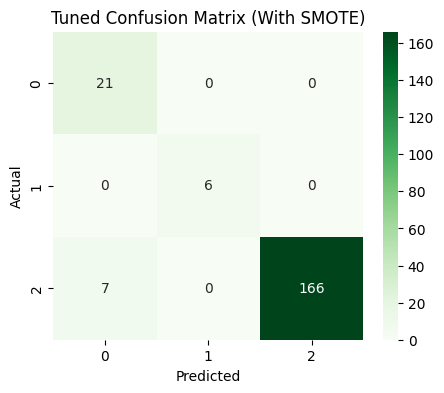

✅ Best model saved as xgb_final.joblib


In [30]:
# Confusion matrix
cm_best = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_best, annot=True, fmt="d", cmap="Greens")
plt.title("Tuned Confusion Matrix (With SMOTE)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 9. Save the best model
joblib.dump(best_model, "xgb_final.joblib")
print("✅ Best model saved as xgb_final.joblib")

In [31]:
import pickle

# Save the trained model as a .pkl file
with open("xgb_finalModel.pkl", "wb") as f:
    pickle.dump(best_model, f)

print("✅ Best model saved as xgb_final.pkl")


✅ Best model saved as xgb_final.pkl
